In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader
IMAGE_SIZE = 64

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [18]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import cv2
import tqdm

class CustomImageDataset(Dataset):
    def __init__(self, dataset_path):

        # Init output data
        x_data = []
        y_data = []
        
        # For each class folder
        for label in os.listdir(dataset_path)[:5]:

            # Initialize variables to retrieve and store images
            curr_path = dataset_path + "/" + label

            # For each image
            for filename in tqdm.tqdm(os.listdir(curr_path)):

                # Store image in tensor representation
                image_path = curr_path + "/" + filename
                image_file = cv2.imread(image_path)
                image_tensor = cv2.resize(image_file, (IMAGE_SIZE, IMAGE_SIZE))
                assert(image_tensor.shape == (IMAGE_SIZE, IMAGE_SIZE, 3))

                # Add tensor to data dictionary
                x_data.append(image_tensor.astype('float32') / 255.0)
                y_data.append(label)

        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        pass

    def __getitem__(self, idx):
        pass

100%|██████████| 4000/4000 [00:01<00:00, 3244.80it/s]


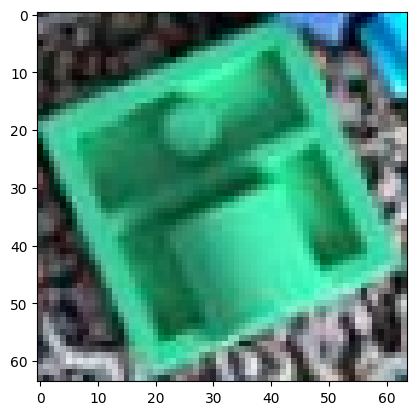

In [19]:
dataset = CustomImageDataset('dataset')
# debugging
plt.imshow(dataset.x_data[100])
plt.show()